In [1]:
import sys
sys.path.append("..")

# NIR Analysis
### Task 01: import all necessary functions

In [2]:
import matplotlib.pyplot as plt

from NIRScanNano.course import DataReader, pca_to_pandas
from NIRScanNano.course import pca_centroids, nearest_centroids, eval_distances
from NIRScanNano.spectrum import average_spectra
from NIRScanNano.visualization import plot_spectrum, pca_pairplot
from NIRScanNano.analysis import snv, savgol, msc
from NIRScanNano.analysis import PCAnalysis

### Task 02: read data from file
(all spectrum files will be automatically included)

In [3]:
data = DataReader("datafile.csv")

### Task 03: select measured spectra by your group data
(compound names were written to the header)

In [4]:
spectra = data.spectra_by_group(1)

In [5]:
example_spectrum = spectra[0]

In [6]:
for key, value in example_spectrum.header.items():
    print(f"{key}: {value}")

Method: Column 1
Host Date-Time: 10/12/20 @ 10:46:32
Header Version: 1
System Temp hundredths: 2704
Detector Temp hundredths: 2235
Humidity hundredths: 1164
Lamp PD: 3665
Shift Vector Coefficients: [-3.96018, 0.0400117, -9.79621e-05]
Pixel to Wavelength Coefficients: [1783.94, -0.91859, -0.000241811]
Serial Number: 6100014
Scan Config Name: Column 1
Scan Config Type: 2
Start wavelength in nm: 900
End wavelength in nm: 1700
Pattern Pixel Width: 6
Number of Measurement points: 228
Num Repeats: 6
PGA Gain: 64
Total Measurement Time (s): 2
Name: Acetaminophen


### select multiple spectra for a compound

In [7]:
example_spectra = [spectrum for spectrum in spectra
                   if spectrum.header["Name"] == "Caffeine"]

### Task 04: perform various analysis tasks
#### SNV and Normalization

In [8]:
norm_spectra = [snv(spectrum, norm=True) for spectrum in example_spectra]
snv_spectra = [snv(spectrum) for spectrum in example_spectra]

#### Multiplicative Scatter Correction
(needs a reference spectrum which is calculated by averaging all spectra)

In [9]:
avg_spectrum = average_spectra(example_spectra)
msc_spectra = [msc(spectrum, avg_spectrum) for spectrum in example_spectra]

Savitzky-Golay Filter (smoothing+derivatives)

In [10]:
savgol_spectra_zero = [savgol(spectrum, 11, 2, 0) for spectrum in example_spectra]
savgol_spectra_first = [savgol(spectrum, 11, 2, 1) for spectrum in example_spectra]

### Task 05: plot all spectra for comparison

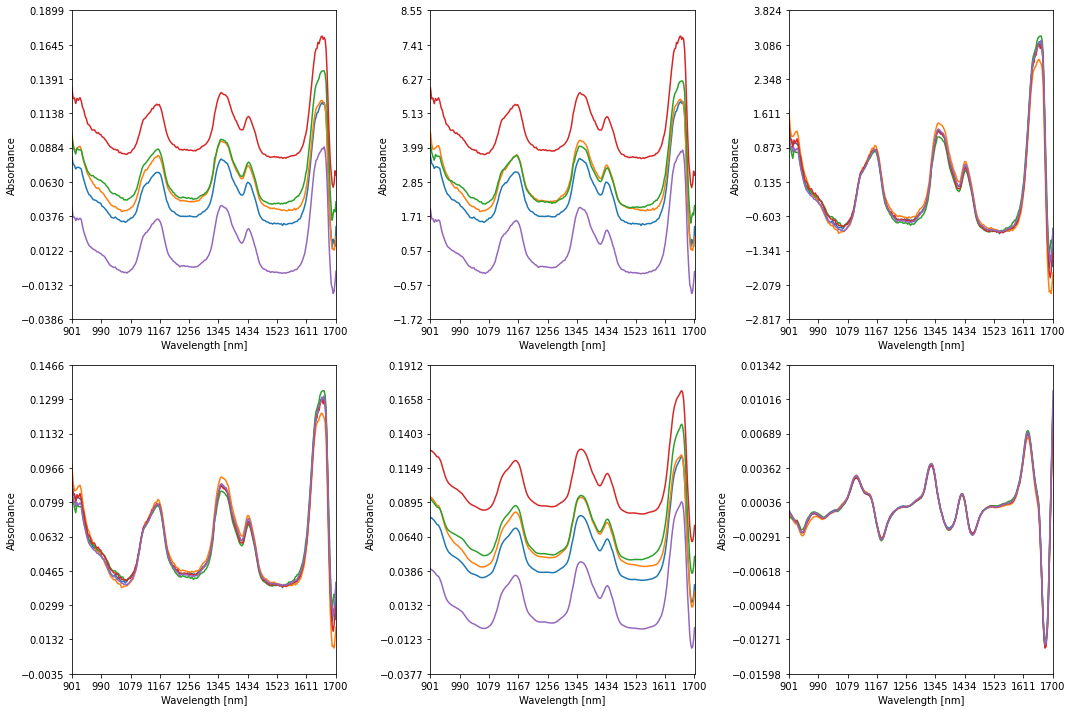

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

plot_spectrum(example_spectra, ax=ax[0,0])
plot_spectrum(norm_spectra, ax=ax[0,1])
plot_spectrum(snv_spectra, ax=ax[0,2])
plot_spectrum(msc_spectra, ax=ax[1,0])
plot_spectrum(savgol_spectra_zero, ax=ax[1,1])
plot_spectrum(savgol_spectra_first, ax=ax[1,2])

fig.tight_layout()

### Task 06: perform a Principal Component Analysis (use SNV)

In [12]:
pca = PCAnalysis([snv(spectrum) for spectrum in spectra])
pca.run()

create a DataFrame from PCA for easier data handling

In [13]:
pca_df = pca_to_pandas(pca, label="Name")

### Task 07: visualize PCA

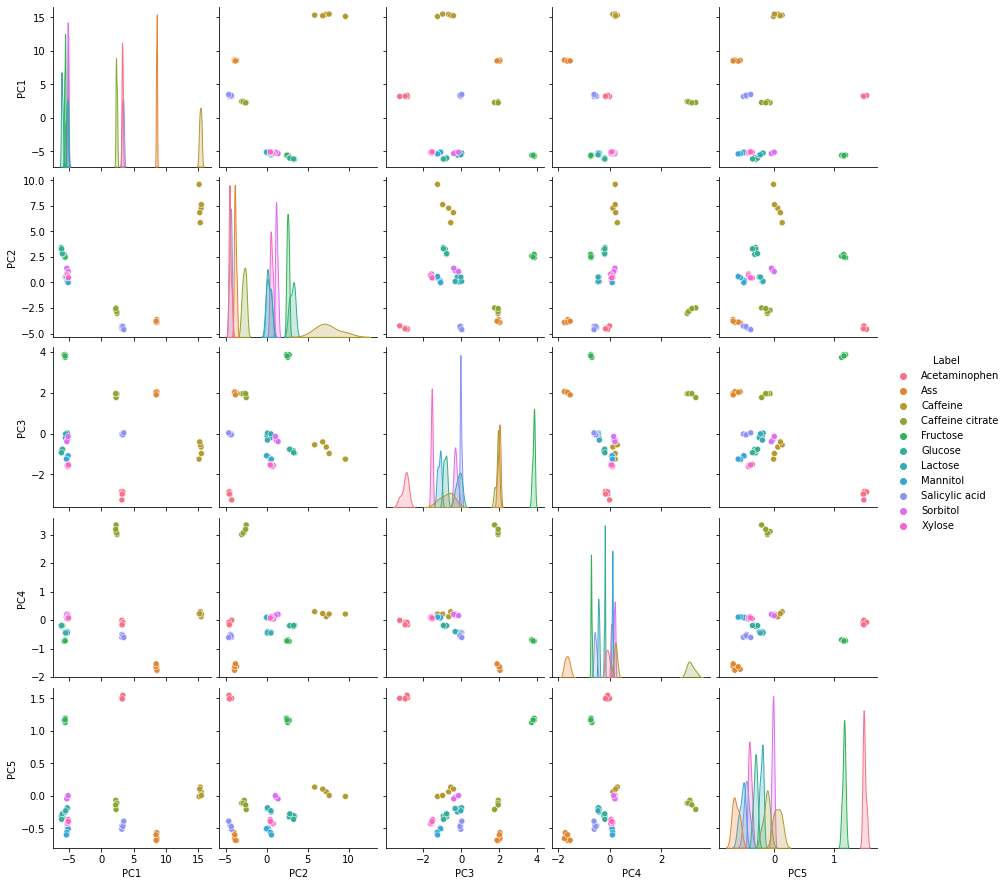

In [14]:
pca_pairplot(pca_df)

### Task 08: select a test spectrum for prediction (use SNV)

In [15]:
test_spectrum = snv(data.random_sample())

calculate the centroids and radii of each compound

In [16]:
# select all principal components
columns = [col for col in pca_df.columns if "PC" in col]

print(columns)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


In [17]:
centroids, max_dist = pca_centroids(pca_df, columns)

In [18]:
centroids

,PC1,PC2,PC3,PC4,PC5
Label,,,,,
Acetaminophen,3.233770,-4.463027,-2.967428,-0.100297,1.507699
Ass,8.539051,-3.826127,1.998039,-1.658987,-0.641755
Caffeine,15.312232,7.430268,-0.767189,0.211664,0.057403
Caffeine citrate,2.320604,-2.727403,1.916088,3.136215,-0.130740
Fructose,-5.641701,2.578495,3.820471,-0.725889,1.165172
Glucose,-6.092554,3.107950,-0.851041,-0.201969,-0.317729
Lactose,-5.373761,0.269489,-0.119559,-0.439208,-0.213307
Mannitol,-5.240422,0.244176,-1.157743,0.092430,-0.537977
Salicylic acid,3.318405,-4.404988,-0.024803,-0.569343,-0.460078


In [19]:
max_dist

Label
Acetaminophen       0.398403
Ass                 0.206643
Caffeine            2.439979
Caffeine citrate    0.388115
Fructose            0.209178
Glucose             0.412085
Lactose             0.361509
Mannitol            0.418835
Salicylic acid      0.298662
Sorbitol            0.273969
Xylose              0.295814
dtype: float64

calculate the distances for the test spectrum to each centroid

In [20]:
distances = nearest_centroids(test_spectrum, pca, centroids, 10)

In [21]:
distances

Label
Fructose             0.197285
Sorbitol             4.700294
Lactose              4.902957
Glucose              4.988433
Mannitol             5.934442
Xylose               6.115678
Caffeine citrate    10.744013
Salicylic acid      12.284211
Acetaminophen       13.400296
Ass                 15.957250
dtype: float64

evaluate the distances and check if we can predict the compound

In [22]:
possible_compounds = eval_distances(distances, max_dist)
print(possible_compounds)

['Fructose']


In [23]:
print(test_spectrum.header["Name"])

Fructose
